In [1]:
import pandas as pd

df = pd.read_csv('images_4.csv')
df

,image,label
0,ea7b6656-3f84-4eb3-9099-23e623fc1018,T-Shirt
1,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,T-Shirt
2,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,Shoes
3,5d3a1404-697f-479f-9090-c1ecd0413d27,Shorts
4,b0c03127-9dfb-4573-8934-1958396937bf,Shirt
...,...,...
5265,female-casual-peach-color-jeans-female-casual-...,Pants
5266,lilac-jeans-wooden-background-lilac-jeans-wood...,Pants
5267,jeans-image-table-48097904,Pants
5268,jeans-white-background-classical-isolated-clos...,Pants


# Encode labels, take sample of data into train/valid/test

In [2]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(df.label)
labels

array([13, 13, 10, ...,  7,  7,  7])

In [3]:
images = df.iloc[:, 0]

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in ss.split(images, labels):
    train_x, test_x = images[train_index], images[test_index]
    train_y, test_y = labels[train_index], labels[test_index]

In [5]:
train_x = train_x.to_numpy()

In [6]:
for train_index, valid_index in ss.split(train_x, train_y):
    train_x, valid_x = train_x[train_index], train_x[valid_index]
    train_y, valid_y = train_y[train_index], train_y[valid_index]

# Get all images loaded in from sample and convert to tensor

In [7]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize

def get_images(path_list):
    train_img = []
    for filename in path_list:
        path = 'images_compressed/' + filename + '.jpg'
        img = imread(path, as_gray=True)
        img = resize(img, (100, 100))
        img /= 255.0
        img = img.astype('float32')
        train_img.append(img)
    return np.asarray(train_img)

In [8]:
train_x_images = get_images(train_x)

In [9]:
train_x_images.shape

(3372, 100, 100)

In [10]:
valid_x_images = get_images(valid_x)
test_x_images = get_images(test_x)

In [11]:
import torch

train_x_torch = torch.from_numpy(train_x_images).unsqueeze(dim=1)
valid_x_torch = torch.from_numpy(valid_x_images).unsqueeze(dim=1)
test_x_torch = torch.from_numpy(test_x_images).unsqueeze(dim=1)

In [12]:
train_x_torch.shape

torch.Size([3372, 1, 100, 100])

In [13]:
train_y_torch = torch.from_numpy(train_y)
valid_y_torch = torch.from_numpy(valid_y)
test_y_torch = torch.from_numpy(test_y)
train_y_torch.shape

torch.Size([3372])

In [14]:
# use gpu if available
if torch.cuda.is_available():
    train_x_torch = train_x_torch.cuda()
    train_y_torch = train_y_torch.cuda()
    valid_x_torch = valid_x_torch.cuda()
    valid_y_torch = valid_y_torch.cuda()
    test_x_torch = test_x_torch.cuda()
    test_y_torch = test_y_torch.cuda()
    

In [15]:
train = list(zip(train_x_torch, train_y_torch.to(dtype=torch.long)))
test = list(zip(test_x_torch, test_y_torch.to(dtype=torch.long)))
valid = list(zip(valid_x_torch, valid_y_torch.to(dtype=torch.long)))

In [16]:
# put everything into a data loader because too much data for gpu

from torch.utils.data import DataLoader

trainloader = DataLoader(train, batch_size=16)
testloader = DataLoader(test, batch_size=16)
validloader = DataLoader(valid, batch_size=16)

# Create CNN model

In [17]:
from torch import nn

# need to figure out what the numbers in Conv2d and other parts are / what to use for them

class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        
        # two layers for this cnn
        self.cnn_layers = nn.Sequential (
            # Defining a 2D convolution layer
            nn.Conv2d(1, 32, kernel_size=9, stride=1, padding=1),   # output = 94 x 94 x 32
            nn.BatchNorm2d(32),                                     # same shape
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # output = 47 X 47 X 32
            # Defining another 2D convolution layer
            nn.Conv2d(32, 32, kernel_size=9, stride=1, padding=1),  # output = 41 X 41 X 32
            nn.BatchNorm2d(32),                                     # same shape
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # output = 20 X 20 X 32
            
            # Defining another 2D convolution layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # output = 20 x 20 x 64
            nn.BatchNorm2d(64),                                     # same shape
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # output = 10 X 10 X 64
      
        )
        
        self.linear_layers = nn.Sequential(
            nn.Linear(64 * 10 * 10, 15)
        )
        
    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
#         print(x.shape)
        x = self.linear_layers(x)
        return x

In [18]:
from torch import optim

model = ConvNN()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

ConvNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=6400, out_features=15, bias=True)
  )
)


In [19]:
# Training loop

train_losses = []
valid_losses = []

epochs = 10
for epoch in range(epochs):
    train_loss = 0.
    valid_loss = 0.
    train_correct = 0
    train_total = 0
    valid_correct = 0
    valid_total = 0
    
    model.train()
    for images, labels in trainloader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        for i in range(len(labels)):
            image = images[i].view(1, 1, 100, 100)
            with torch.no_grad():
                logps = model(image)
            allprobs = torch.exp(logps)
            prob = allprobs.tolist()[0]
            hyp = prob.index(max(prob))
            train_y = labels[i]
            train_total += 1
            if train_y.item() == hyp:
                train_correct += 1
                
    train_losses.append(train_loss/len(trainloader))
    
    model.eval()
    for images, labels in validloader:
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()
        for i in range(len(labels)):
            image = images[i].view(1, 1, 100, 100)
            with torch.no_grad():
                logps = model(image)
            allprobs = torch.exp(logps)
            prob = allprobs.tolist()[0]
            hyp = prob.index(max(prob))
            valid_y = labels[i]
            valid_total += 1
            if valid_y.item() == hyp:
                valid_correct += 1
                
    valid_losses.append(valid_loss/len(validloader))
    
    print('At epoch', epoch, 'loss =', '%.3g'%(train_loss/len(trainloader)), 'train acc=', '%.3g'%(train_correct/train_total), 'valid loss =', '%.3g'%(valid_loss/len(validloader)), 'valid acc =', '%.3g'%(valid_correct/valid_total))
    
import matplotlib.pyplot as plt



At epoch 0 loss = 2.02 train acc= 0.39 valid loss = 1.71 valid acc = 0.492
At epoch 1 loss = 1.49 train acc= 0.527 valid loss = 1.45 valid acc = 0.565
At epoch 2 loss = 1.22 train acc= 0.602 valid loss = 1.33 valid acc = 0.596
At epoch 3 loss = 1.03 train acc= 0.656 valid loss = 1.28 valid acc = 0.62
At epoch 4 loss = 0.877 train acc= 0.695 valid loss = 1.25 valid acc = 0.627
At epoch 5 loss = 0.749 train acc= 0.726 valid loss = 1.22 valid acc = 0.645
At epoch 6 loss = 0.64 train acc= 0.754 valid loss = 1.21 valid acc = 0.643
At epoch 7 loss = 0.545 train acc= 0.785 valid loss = 1.21 valid acc = 0.647
At epoch 8 loss = 0.462 train acc= 0.809 valid loss = 1.18 valid acc = 0.647
At epoch 9 loss = 0.389 train acc= 0.835 valid loss = 1.18 valid acc = 0.646


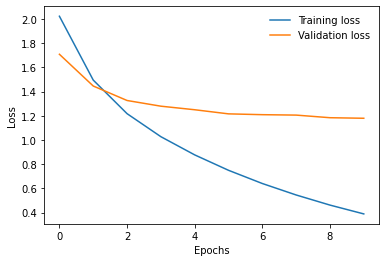

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [21]:
correct = 0.
total = 0.

hyps = []
correct_labels = []

model.eval()
for images, labels in testloader:
    for i in range(len(labels)):
        image = images[i].view(1, 1, 100, 100)
        with torch.no_grad():
            logps = model(image)
        allprobs = torch.exp(logps)
        prob = allprobs.tolist()[0]
        hyp = prob.index(max(prob))
        hyps.append(hyp)
        test_y = labels[i]
        total += 1
        correct_labels.append(test_y.item())
        if test_y.item() == hyp:
            correct += 1

print(correct/total)

0.6110056925996205


In [22]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(correct_labels, hyps)
cm

array([[  8,   0,   0,   0,   1,   5,   3,   1,   0,   3,   0,   0,   1,
          0,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,
          3,   1],
       [  2,   0,  31,   0,   0,   6,   1,   4,   1,   6,   0,   3,   2,
         14,   1],
       [  1,   0,   0,   9,   0,   7,   0,   3,   0,   4,   3,   1,   3,
          3,   0],
       [  0,   0,   1,   0,   3,  10,   3,   0,   0,   1,   1,   0,   0,
          1,   0],
       [  1,   0,   0,   2,   3,  94,   4,   3,   0,  14,   2,   1,   1,
         13,   2],
       [  0,   0,   4,   0,   3,  21,  16,   3,   2,   9,   0,   1,   2,
          1,   0],
       [  1,   0,   1,   0,   2,   2,   1, 130,   1,   9,   2,   7,   0,
          3,   0],
       [  0,   0,   0,   0,   0,   1,   1,   0,   8,   3,   0,   0,   0,
         11,   0],
       [  3,   0,   2,   0,   0,  21,   3,   5,   0,  64,   4,   2,   0,
          9,   0],
       [  0,   0,   2,   1,   0,   2,   1,   9,   0,   1,  62,   8,   0,
       

In [27]:
from sklearn.metrics import classification_report

print(classification_report(correct_labels, hyps, target_names=['Blazer', 'Blouse', 'Dress', 'Hat', 'Hoodie', 'Longsleeve',
       'Outwear', 'Pants', 'Polo', 'Shirt', 'Shoes', 'Shorts', 'Skirt',
       'T-Shirt', 'Undershirt']))

              precision    recall  f1-score   support

      Blazer       0.50      0.36      0.42        22
      Blouse       0.00      0.00      0.00         5
       Dress       0.60      0.44      0.50        71
         Hat       0.69      0.26      0.38        34
      Hoodie       0.23      0.15      0.18        20
  Longsleeve       0.51      0.67      0.58       140
     Outwear       0.46      0.26      0.33        62
       Pants       0.74      0.82      0.78       159
        Polo       0.47      0.33      0.39        24
       Shirt       0.50      0.57      0.53       113
       Shoes       0.78      0.72      0.75        86
      Shorts       0.58      0.71      0.64        62
       Skirt       0.37      0.23      0.28        31
     T-Shirt       0.70      0.80      0.75       202
  Undershirt       0.50      0.26      0.34        23

    accuracy                           0.61      1054
   macro avg       0.51      0.44      0.46      1054
weighted avg       0.60   

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
